<a href="https://colab.research.google.com/github/ANUSHKALA/food-data-nutrition-analysis_project/blob/main/food_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project - Food Nutrition Analysis

#### **Yuxuan Gao, Raunaq Singh, Daniel Duan**

## Introduction

*NOTE: We originally planned to do a blog post as our deliverable, but we have instead done an annotated notebook.*

Welcome to our final project, where we conduct an analysis of food nutrition using the Open Food Facts dataset provided by Kaggle! This dataset contains nutrition facts about food products from all over the world. First, we'll spend some time cleaning up and reformatting the raw data while analyzing it for any interesting observations or correlations. Next, we'll focus on using and testing multiple models (Decision Tree, Logistic Regression, Linear Regression, Random Forest Regression) to see if we can accurately predict a product's nutrition score based on major ingredients in the product. We also will use computer vision to attempt to train a model to classify foods as "Very Healthy," "Moderately Healthy," "Moderately Unhealthy," or "Very Unhealthy" based off of their images. Lastly, we conduct a brief regression analysis on how much energy food items provide.

## Required Setup
In order to download the raw dataset from Kaggle you will need access to your Kaggle credentials (i.e. username and API Key). Here are the necessary steps to do so:
1. Create an account on [Kaggle](https://www.kaggle.com/).
2. Sign in to [Kaggle](https://kaggle.com), then click on your profile picture on the top right and select "My Account" from the menu.
3. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:
```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```
4. When you run `od.download` (In the **Library Setup** section of the notebook), you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 3.

## Library Setup 
Run the following cells to import the necessary packages and load the raw dataset from Kaggle into a Pandas dataframe.

In [113]:
!pip install opendatasets
!pip3 install --upgrade mxnet-cu101 gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from string import ascii_letters
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn as sklearn

In [115]:
# Download raw dataset from Kaggle
od.download("https://www.kaggle.com/openfoodfacts/world-food-facts")

Skipping, found downloaded files in "./world-food-facts" (use force=True to force download)


Now let's populate our dataframe

Awesome! Let's see what `food_df` looks like. 

In [116]:
# Load tsv file into dataframe food_df
food_df = pd.read_table("world-food-facts/en.openfoodfacts.org.products.tsv", error_bad_lines=False, lineterminator='\n')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,20,24,25,26,28,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [117]:
# See what the food_df looks like!
food_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling and Cleaning
As you can see above, `food_df` is currently quite unorganized and presented in a form that is not very helpful for our purposes: there are many entires with `NaN` values in different varying columns, there are a lot of extraneous columns with few values that aren't `NaN`, some products belong to multiple countries, etc. etc. This section will focus on cleaning up `food_df` and making it more presentable.  

First, we make sure to drop any duplicate values that may appear within the dataframe.
Then, we only keep the columns with sufficient data and that are important contributors to a food's overall nutrition. For example, we will keep `fat_100g`, `cholesterol_100g`, etc. We decided to drop columns like `folates_100g` that are sparsely filled and not extremely indicative of a product's nutrition score. We mainly chose this list of columns based off of our own intutition. 

In [118]:
# Remove duplicate values
food_df = food_df.drop_duplicates()

# Only Select columns with sufficient data and of great predictive value
food_df = food_df[["product_name", "countries_en", "image_url", "ingredients_text", "fat_100g", "cholesterol_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g", "energy_100g", "nutrition-score-uk_100g"]].dropna()
food_df.head(5)

,product_name,countries_en,image_url,ingredients_text,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
315,Sea Salt Potato Chips,United States,http://en.openfoodfacts.org/images/products/00...,"Unpeeled potatoes, sunflower oil, sea salt.",32.14,0.0000,57.14,0.00,3.600,7.14,0.375,2243.0,8.0
546,Pizza Parlanno,United States,http://en.openfoodfacts.org/images/products/00...,"Crust: _Wheat_ Flour, Water, Olive Oil, Salt,...",12.00,0.0226,25.60,3.76,0.752,9.77,0.481,1070.0,11.0
608,Mac 'n Cheese,United States,http://en.openfoodfacts.org/images/products/00...,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",7.58,0.0202,21.20,1.52,0.505,8.08,0.298,761.0,4.0
770,Hello Panda,United States,http://en.openfoodfacts.org/images/products/00...,"Wheat flour, vegetable shortening (partially h...",26.70,0.0333,66.70,33.30,6.670,6.67,0.367,2230.0,22.0
951,sharon's sorbet mango,United States,http://en.openfoodfacts.org/images/products/00...,"Mango puree, water, cane sugar, lemon juice, p...",0.00,0.0000,26.00,25.00,1.040,0.00,0.000,435.0,5.0


`food_df` already looks much cleaner! We now have a dataframe consisting of non-empty values of important ingredients. Let's check the datatype of each remaining column.

In [119]:
# Check data types of the columns
food_df.dtypes

product_name                object
countries_en                object
image_url                   object
ingredients_text            object
fat_100g                   float64
cholesterol_100g           float64
carbohydrates_100g         float64
sugars_100g                float64
fiber_100g                 float64
proteins_100g              float64
sodium_100g                float64
energy_100g                float64
nutrition-score-uk_100g    float64
dtype: object

Next, notice how some products appear in multiple countries (i.e. in their `countries_en` column, their value is `United States, France, Germany`). Let's split up those products using the `explode` function. 

In [120]:
# split up proudcts that are sold in multiply countries
food_df["countries_en"]=food_df["countries_en"].str.split(",")
food_df = food_df.explode("countries_en").reset_index(drop=True)
food_df.head(5)

,product_name,countries_en,image_url,ingredients_text,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
0,Sea Salt Potato Chips,United States,http://en.openfoodfacts.org/images/products/00...,"Unpeeled potatoes, sunflower oil, sea salt.",32.14,0.0000,57.14,0.00,3.600,7.14,0.375,2243.0,8.0
1,Pizza Parlanno,United States,http://en.openfoodfacts.org/images/products/00...,"Crust: _Wheat_ Flour, Water, Olive Oil, Salt,...",12.00,0.0226,25.60,3.76,0.752,9.77,0.481,1070.0,11.0
2,Mac 'n Cheese,United States,http://en.openfoodfacts.org/images/products/00...,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",7.58,0.0202,21.20,1.52,0.505,8.08,0.298,761.0,4.0
3,Hello Panda,United States,http://en.openfoodfacts.org/images/products/00...,"Wheat flour, vegetable shortening (partially h...",26.70,0.0333,66.70,33.30,6.670,6.67,0.367,2230.0,22.0
4,sharon's sorbet mango,United States,http://en.openfoodfacts.org/images/products/00...,"Mango puree, water, cane sugar, lemon juice, p...",0.00,0.0000,26.00,25.00,1.040,0.00,0.000,435.0,5.0


The dataframe looks clean and ready to use now!

## EDA
Now let's see if we can find any cool observations from the dataset using **exploratory data analysis**. 
Note that we describe and interpret any relevant findings **after** each code snippet. 



First, let's compute some simple statistics between the numeric columns in `food_df`. These columns include `fat_100g`, `cholesterol_100g`, etc. etc. 

In [121]:
# Calculate the max, min, standard deviation, and mean of all the numeric columns
numeric_df = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'ingredients_text'])
maxes = numeric_df.max().tolist()
mins = numeric_df.min().tolist()
stds = numeric_df.std().tolist()
means = numeric_df.mean().tolist()

print(maxes)
print(mins)
print(stds)
print(means)

[100.0, 10.9, 136.0, 134.0, 66.7, 78.9, 39.0, 3925.0, 31.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -10.0]
[20.35188452558032, 0.28312752018584897, 29.441685321008933, 18.351733349580634, 4.664659377301253, 7.484750700217556, 1.452184747437497, 860.6874383927535, 9.278451796446975]
[15.68266090425532, 0.01950267819148936, 35.550280585106385, 13.96849534574468, 3.1559607712765962, 7.382564494680851, 0.49229202337598427, 1293.6662187499999, 8.528590425531915]


 From this, we can see that the amount of certain ingredients can vary immensely among products. For example, the calculated standard deviation of `energy_100g` is `860`. Some food products provide so much more energy than others!

Next, let's get a visual representation of the most popular ingredients used in products through a Word Cloud. 

<function matplotlib.pyplot.show>

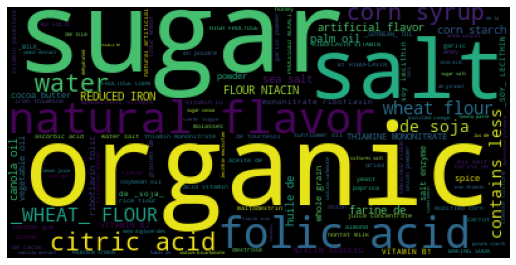

In [122]:
# Explode the ingreidents_text
copy_food_df = food_df.copy()
copy_food_df['ingredients_text'] = copy_food_df['ingredients_text'].str.split(',').tolist()
copy_food_df = copy_food_df.explode('ingredients_text')

# generate a Word Cloud based on the ingredients
ingredients_word_cloud = WordCloud().generate(' '.join(copy_food_df['ingredients_text']))
plt.imshow(ingredients_word_cloud)
plt.axis("off")
plt.show


From this, we can see that sugar and salt seem to be the most relevant ingredients in most products, which doesn't really come of as a surprise. 

Now let's group the food products by country and visually represent each countries average nutrition score. To do this, we have to first split up foods that belong to mulitple countries using the `explode` function. Then, since some countries only have one or two food products associated with them, we should only consider countries that produce over three food products. 

***Note: The lower the nutrition score, the healthier the food is!***

Text(0.5, 1.0, 'Average Nutrition Score for Foods by Country')

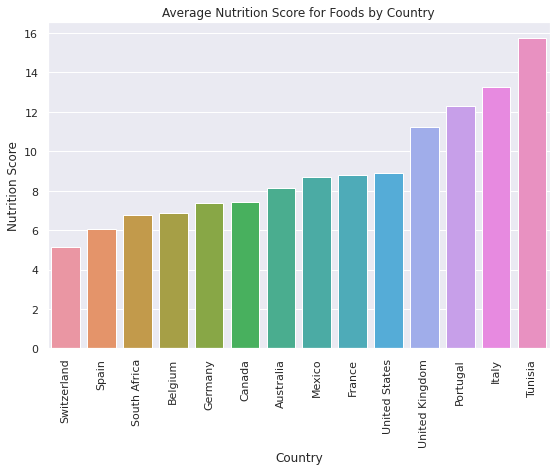

In [123]:
#split up foods with multiply countries
food_df["countries_en"]=food_df["countries_en"].str.split(",")
country_exploded_df = food_df.explode("countries_en").reset_index(drop=True)

#only consider countries with over 3 products in the dataframe
country_count_df = country_exploded_df.groupby(["countries_en"], as_index=False).count()[["countries_en", "product_name"]]
country_count_df = country_count_df[country_count_df["product_name"] > 3]

country_nutrition_df = country_exploded_df.groupby(["countries_en"], as_index=False).mean().round(2)[["countries_en", "nutrition-score-uk_100g"]]
country_nutrition_df = country_nutrition_df.merge(country_count_df[["countries_en"]], left_on=["countries_en"], right_on=["countries_en"])

#NOTE: lower nutrition-score -> healthier
country_nutrition_df.sort_values(["nutrition-score-uk_100g"], ascending=[False])

#Map Visualization
plot = sns.barplot(x="countries_en", y="nutrition-score-uk_100g", data=country_nutrition_df, order=country_nutrition_df.sort_values(["nutrition-score-uk_100g"], ascending=[True])["countries_en"])
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Nutrition Score")
plt.title("Average Nutrition Score for Foods by Country")


Nice! Out of the countries that have more than 3 food products associated with them, our graph indicates that Switzerland produces the healthiest food items, while Tunisia products the least healthy food items. 

Next let's plot a correlation heatmap to see just how closely certain ingredients are correlated with each other. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


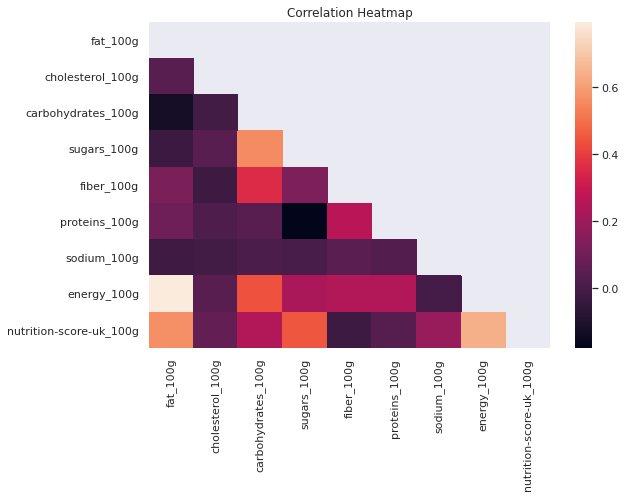

In [124]:
# Plot correlation heatmap for all pairs of variables
sns.set(style = "white")
sns.set(rc={'figure.figsize':(9,6)})

corr = food_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask)

plt.title("Correlation Heatmap")
plt.show()

In [125]:
# Display correlation matrix
corr

,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
fat_100g,1.000000,0.045731,-0.125071,-0.032149,0.123092,0.095489,-0.021479,0.792552,0.567827
cholesterol_100g,0.045731,1.000000,-0.009278,0.041228,-0.027423,0.019461,-0.007999,0.039910,0.069505
carbohydrates_100g,-0.125071,-0.009278,1.000000,0.556873,0.357107,0.040045,0.011736,0.441718,0.248067
sugars_100g,-0.032149,0.041228,0.556873,1.000000,0.128337,-0.181423,0.006351,0.229902,0.447714
fiber_100g,0.123092,-0.027423,0.357107,0.128337,1.000000,0.260167,0.049298,0.247903,-0.025244
proteins_100g,0.095489,0.019461,0.040045,-0.181423,0.260167,1.000000,0.028233,0.246367,0.038277
sodium_100g,-0.021479,-0.007999,0.011736,0.006351,0.049298,0.028233,1.000000,-0.003170,0.188552
energy_100g,0.792552,0.039910,0.441718,0.229902,0.247903,0.246367,-0.003170,1.000000,0.642317
nutrition-score-uk_100g,0.567827,0.069505,0.248067,0.447714,-0.025244,0.038277,0.188552,0.642317,1.000000


From the Correlation Heatmap, visually we can see that `fat_100g` has significant correlation with `carbohydrates_100g` and `sugars_100g` is significantly correlated with `proteins_100g`. In order to address any possible issues with multicollinearity, in our `Modeling` section we'll be sure to use PCA beforehand. 

Let's look a little more closely at how certain ingredients are correlated with a product's overall nutrition score. We'll primarily be focusing on the correlation between fat and nutrition score. Let's first run a linear regression analysis between `fat_100g` and `nutrition-score-uk_100g` and report the `R-squared` value. 

R-squared value on training set is: 32.24 %


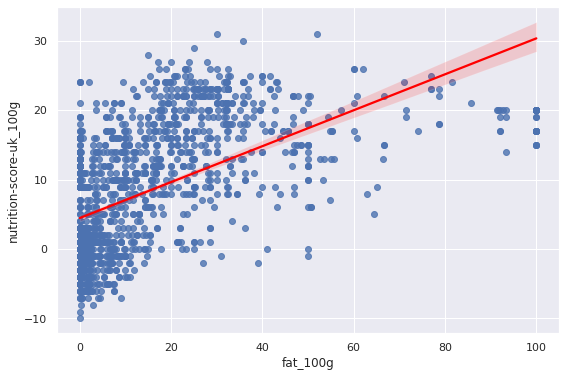

In [126]:
# Linear regression analysis of variables fat_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['fat_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

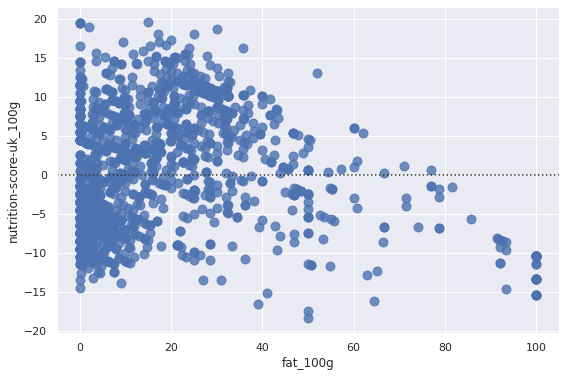

In [127]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 0.48 %


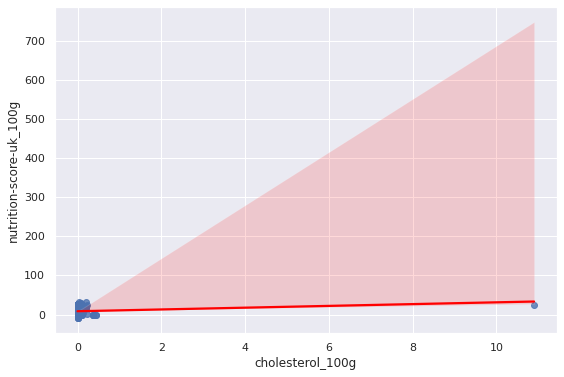

In [128]:
# Linear regression analysis of variables cholesterol_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['cholesterol_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="cholesterol_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

From this linear regression analysis we can see that the R-squared value is only 32.24%, which isn't very high. We can see visually however that there does appear to be a slight positive correlation between `fat_100g` and `nutrition-score-uk_100g`. Let's see if we can test the accuracy of our linear regression by analysing a plot of the residuals. 

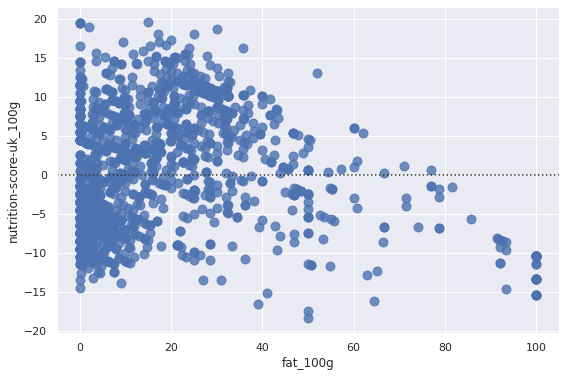

In [129]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 20.04 %


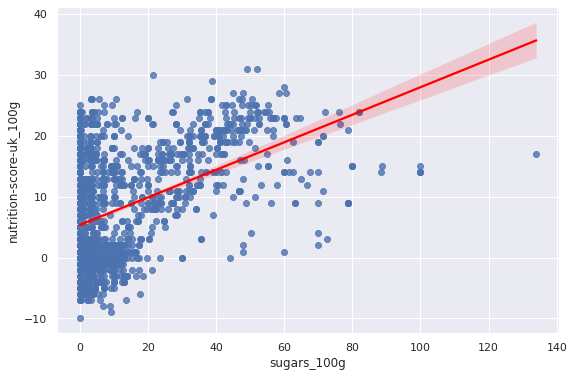

In [130]:
# Linear regression analysis of variables sugars_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['sugars_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="sugars_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

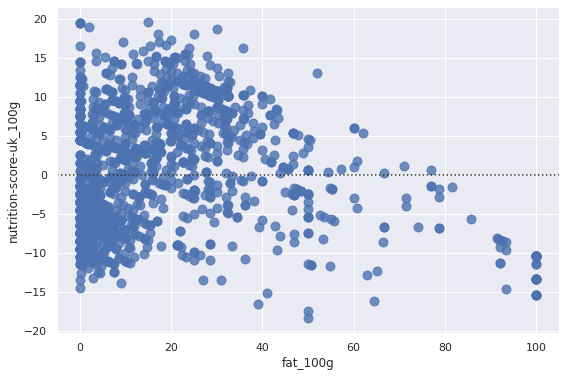

In [131]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 0.06 %


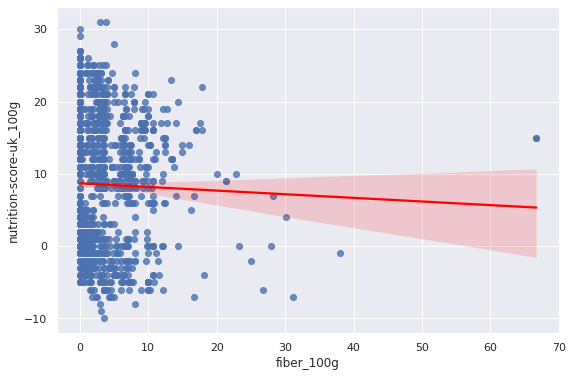

In [132]:
# Linear regression analysis of variables fiber_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['fiber_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="fiber_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

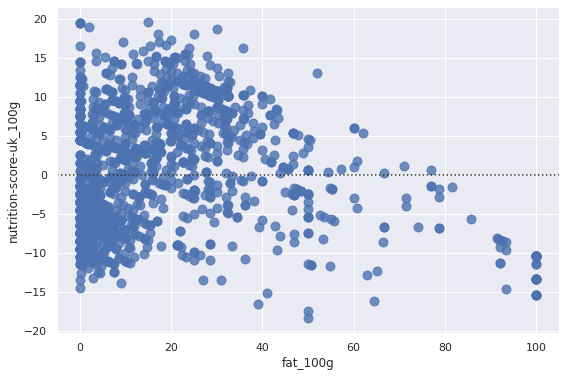

In [133]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 41.26 %


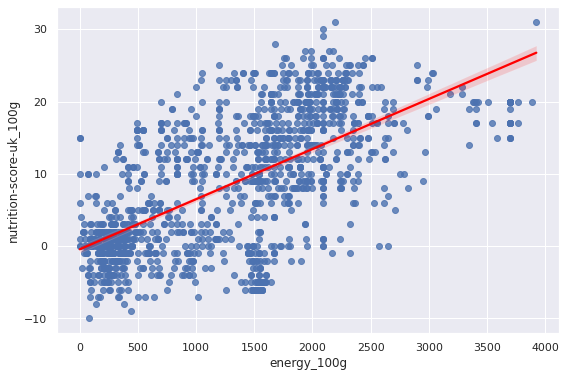

In [134]:
# Linear regression analysis of variables energy_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['energy_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="energy_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

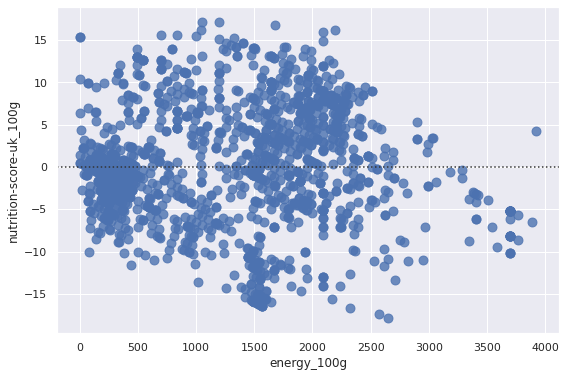

In [135]:
# Plot residuals from the prediction
sns.residplot(x="energy_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 0.15 %


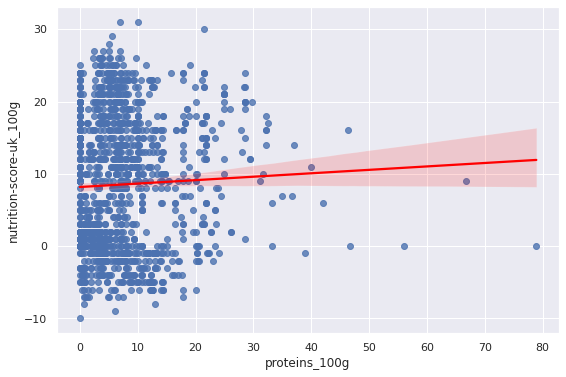

In [136]:
# Linear regression analysis of variables proteins_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['proteins_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="proteins_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

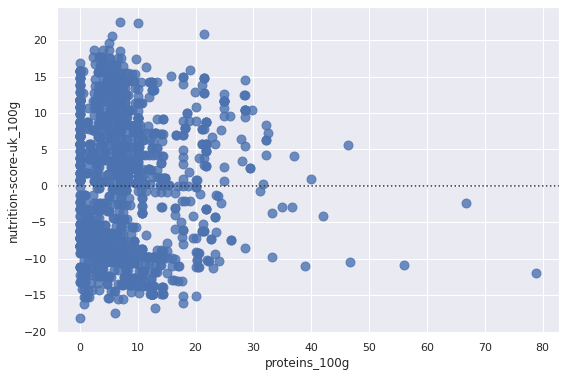

In [137]:
# Plot residuals from the prediction
sns.residplot(x="proteins_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 3.56 %


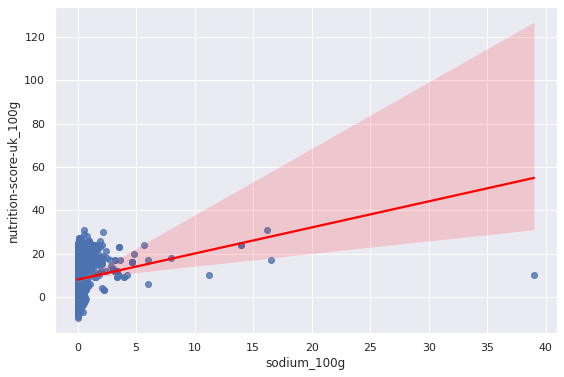

In [138]:
# Linear regression analysis of variables sodium_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['sodium_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="sodium_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

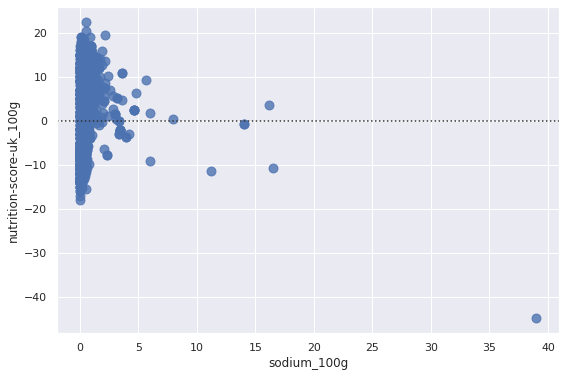

In [139]:
# Plot residuals from the prediction
sns.residplot(x="sodium_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

R-squared value on training set is: 3.56 %


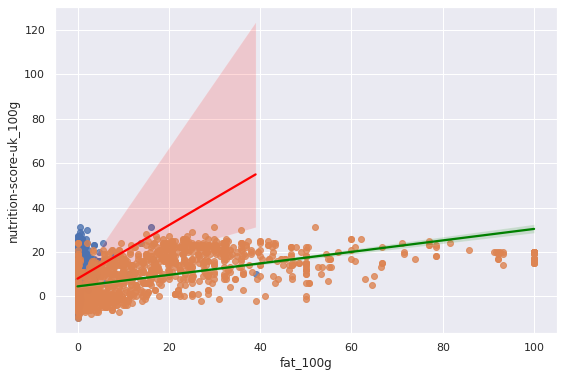

In [140]:
# Linear regression analysis of variables sodium_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['sodium_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="sodium_100g", y="nutrition-score-uk_100g", data=food_df,line_kws={'color':'red'})
ax1 = sns.regplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df,line_kws={'color':'green'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

R-squared value on training set is: 3.56 %


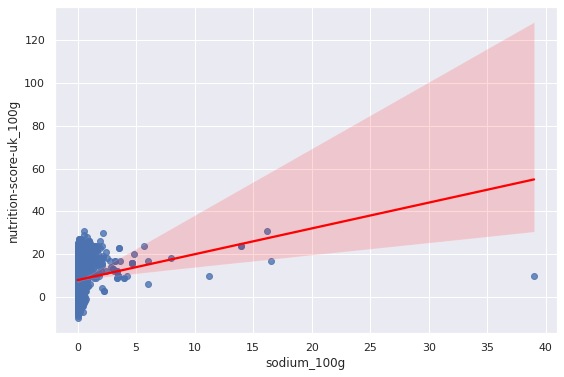

In [141]:
# Linear regression analysis of variables sodium_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['sodium_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="sodium_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

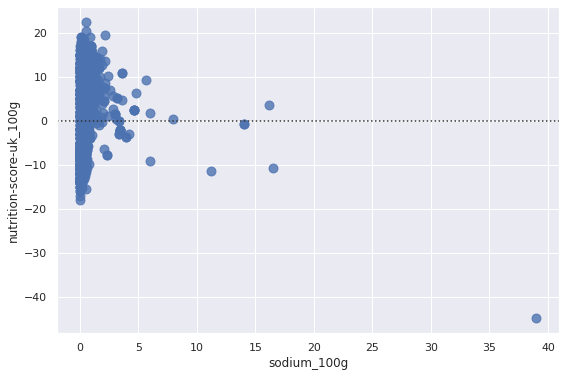

In [142]:
# Plot residuals from the prediction
sns.residplot(x="sodium_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

Hmmm... It seems that the points aren't very randomly disperesed around the horiziontal axis. Let's try our luck with a polynomial regression analysis between `fat_100g` and `nutrition-score-uk_100g`, and see if a polynomial regression model can be more accurate. 

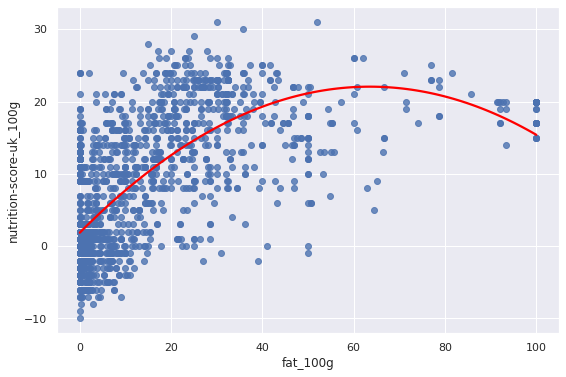

In [143]:
# Polynomial regression analysis of variables fat_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
ax = sns.regplot(x="fat_100g", y="nutrition-score-uk_100g", order=2, ci=None, data=food_df, line_kws={'color':'red'})

It seems that the data points are slighly more dispersed when compared to our analysis using `linear regression`!

In [144]:
# Save a copy of the original dataframe
food_plain_df = food_df

## Feature Engineering
In this section let's quickly focus on **feature engineering** and see if we can further prepare our data for our machine learning algorithms, focusing on performance imporvement.  

Let's start by performing a one great encoding of the ingredients in order to better format the data for our future machine learning algorithms. 

In [145]:
# Perform one hot encoding of ingridients
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter

le = LabelEncoder()
all_ingredients = []

def ingredients_text_to_list(ingredients_text):
  without_parens = re.sub(r"\([^()]*\)", "", ingredients_text.lower())
  without_punc = re.sub("[^A-Za-z0-9,]+", " ", without_parens)
  ingredients_list = without_punc.split(',')
  ingredients_list = [s.strip() for s in ingredients_list]
  all_ingredients.extend(ingredients_list)
  return ingredients_list
  
def removeInsignificantElements(ingredients_list, significance):
    counted = Counter(ingredients_list)
    return [s for s in ingredients_list if (counted[s] >= significance and s and all(x.isalpha() or x.isspace() for x in s))]

def update_ingredients_list(ingredients_list):
  return [s for s in ingredients_list if s in all_ingredients]


food_df["ingredients_list"] = food_df["ingredients_text"].apply(ingredients_text_to_list)

# don't consider ingredients that appear less than 10 times
all_ingredients = removeInsignificantElements(all_ingredients, 10)

food_df["ingredients_list"] = food_df["ingredients_list"].apply(update_ingredients_list)

le.fit(all_ingredients)

for ingredient in le.classes_:
  food_df[ingredient] = 0

for index, row in food_df.iterrows():
  for ingredient in row["ingredients_list"]:
    food_df[ingredient][index] = 1

food_df = food_df.drop(['ingredients_text', 'ingredients_list'], axis=1)
food_df.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,product_name,countries_en,image_url,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,...,wheat gluten,wheat starch,whey,whey protein concentrate,whole grain oats,whole wheat flour,xanthan gum,yeast,yeast extract,zinc oxide
0,Sea Salt Potato Chips,[United States],http://en.openfoodfacts.org/images/products/00...,32.14,0.0000,57.14,0.00,3.600,7.14,0.3750,...,0,0,0,0,0,0,0,0,0,0
1,Pizza Parlanno,[United States],http://en.openfoodfacts.org/images/products/00...,12.00,0.0226,25.60,3.76,0.752,9.77,0.4810,...,0,0,0,0,0,0,0,1,0,0
2,Mac 'n Cheese,[United States],http://en.openfoodfacts.org/images/products/00...,7.58,0.0202,21.20,1.52,0.505,8.08,0.2980,...,0,0,0,0,0,0,0,0,0,0
3,Hello Panda,[United States],http://en.openfoodfacts.org/images/products/00...,26.70,0.0333,66.70,33.30,6.670,6.67,0.3670,...,0,0,0,0,0,0,0,0,0,0
4,sharon's sorbet mango,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,26.00,25.00,1.040,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,0
5,Spaghetti sauce with mushrooms,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,8.62,5.17,1.720,1.72,0.3190,...,0,0,0,0,0,0,0,0,0,0
6,Creme Brulee,[United States],http://en.openfoodfacts.org/images/products/00...,40.00,0.0500,50.00,50.00,2.500,5.00,0.0875,...,0,0,0,0,0,0,0,0,0,0
7,Creation Hazelnut Torte Milk Chocolate,[United States],http://en.openfoodfacts.org/images/products/00...,32.50,0.0125,55.00,52.50,2.500,7.50,0.0625,...,0,0,0,0,0,0,0,0,0,0
8,Molten Lava Cake,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0250,55.00,50.00,2.500,5.00,0.0625,...,0,0,0,0,0,0,0,0,0,0
9,Mini Cups,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0167,56.70,56.70,3.330,6.67,0.0333,...,0,0,0,0,0,0,0,0,0,0


In [146]:
# Synthesize indicator variable that equals to 1 if the nutritient score is above average, 0 otherwise
pd.options.mode.chained_assignment = None
food_df['nutrition_above_avg'] = food_df['nutrition-score-uk_100g'].apply(lambda x : 1 if x > food_df['nutrition-score-uk_100g'].mean() else 0)
food_df.head(15)

,product_name,countries_en,image_url,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,...,wheat starch,whey,whey protein concentrate,whole grain oats,whole wheat flour,xanthan gum,yeast,yeast extract,zinc oxide,nutrition_above_avg
0,Sea Salt Potato Chips,[United States],http://en.openfoodfacts.org/images/products/00...,32.14,0.0000,57.14,0.00,3.600,7.14,0.3750,...,0,0,0,0,0,0,0,0,0,0
1,Pizza Parlanno,[United States],http://en.openfoodfacts.org/images/products/00...,12.00,0.0226,25.60,3.76,0.752,9.77,0.4810,...,0,0,0,0,0,0,1,0,0,1
2,Mac 'n Cheese,[United States],http://en.openfoodfacts.org/images/products/00...,7.58,0.0202,21.20,1.52,0.505,8.08,0.2980,...,0,0,0,0,0,0,0,0,0,0
3,Hello Panda,[United States],http://en.openfoodfacts.org/images/products/00...,26.70,0.0333,66.70,33.30,6.670,6.67,0.3670,...,0,0,0,0,0,0,0,0,0,1
4,sharon's sorbet mango,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,26.00,25.00,1.040,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,0
5,Spaghetti sauce with mushrooms,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,8.62,5.17,1.720,1.72,0.3190,...,0,0,0,0,0,0,0,0,0,0
6,Creme Brulee,[United States],http://en.openfoodfacts.org/images/products/00...,40.00,0.0500,50.00,50.00,2.500,5.00,0.0875,...,0,0,0,0,0,0,0,0,0,1
7,Creation Hazelnut Torte Milk Chocolate,[United States],http://en.openfoodfacts.org/images/products/00...,32.50,0.0125,55.00,52.50,2.500,7.50,0.0625,...,0,0,0,0,0,0,0,0,0,1
8,Molten Lava Cake,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0250,55.00,50.00,2.500,5.00,0.0625,...,0,0,0,0,0,0,0,0,0,1
9,Mini Cups,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0167,56.70,56.70,3.330,6.67,0.0333,...,0,0,0,0,0,0,0,0,0,1


## Modeling

### Structure Train & Test Datasets - Nutrition Score Classification

Let's first use `nutrition_above_avg` as our response variable and conduct classification. We will utilize Sklearn's built-in packages to split the training and test sets.

In [147]:
# Use sklearn to split data into train and test sets
from sklearn.model_selection import train_test_split

features = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'nutrition-score-uk_100g','nutrition_above_avg'])
labels = food_df[['nutrition_above_avg']]

print(features.head(5))
print(labels.head(5))

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

   fat_100g  cholesterol_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0     32.14            0.0000               57.14         0.00       3.600   
1     12.00            0.0226               25.60         3.76       0.752   
2      7.58            0.0202               21.20         1.52       0.505   
3     26.70            0.0333               66.70        33.30       6.670   
4      0.00            0.0000               26.00        25.00       1.040   

   proteins_100g  sodium_100g  energy_100g  a b vitamin  aceite de girasol  \
0           7.14        0.375       2243.0            0                  0   
1           9.77        0.481       1070.0            0                  0   
2           8.08        0.298        761.0            0                  0   
3           6.67        0.367       2230.0            0                  0   
4           0.00        0.000        435.0            0                  0   

   ...  wheat gluten  wheat starch  whey  whey protein concent

### Principal Component Analysis

To ensure that multicollinearity is not affecting our prediction and to reduce the number of features to speed things up, we first conduct a PCA analysis to extract out the most important features.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Top 175 variables explain 3.67 % of the total variance


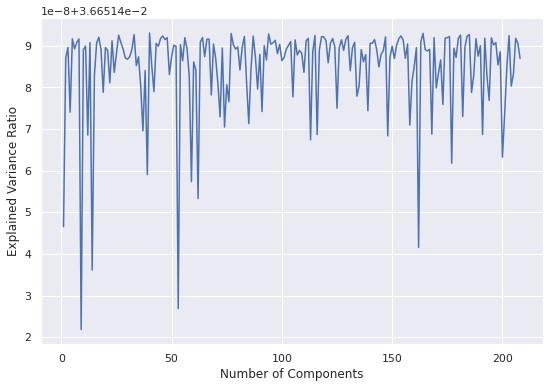

In [148]:
# PCA analysis on useful predictors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
max = 208

thres = []
for i in range(1, max + 1):
  thres.append(i)

explained_ratio = []
explained = []
for i in range(1, max + 1):
  ratio = 0
  pca = PCA(n_components=1)
  pca.fit(x_train_scaled)
  var = pca.explained_variance_ratio_
  for x in var:
    ratio += x
  explained.append(ratio)
  if i == max:
    explained_ratio = var

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.plot(thres, explained)
print("Top 175 variables explain", round(explained[174] * 100, 2), "% of the total variance")

It appears that there is not a clear threshold after which the explained variance ratio stops to grow with the increases in the number of components. Let's print out the explained variance array to examine this issue closely.

In [149]:
# Explained variance ratio
print(explained_ratio)

[0.03665149]


It appears that there is not a set of variables that can explain the bulk of the variance. The best variable can only explain around 3.67% of the label variance. Therefore, we will select a larger amount of fetures to ensure the accuracy of our prediction. 150 seems to be a good choice as the top 175 variables can cover approximately 97.5% of the total variance.

In [150]:
# Select 175 components according to the Elbow Rule
pca = PCA(n_components=175)
pca.fit(x_train_scaled)
x_test = pca.transform(x_test_scaled)
x_train = pca.transform(x_train_scaled)

Let's visualize the distribution of the data points with the top 2 components.

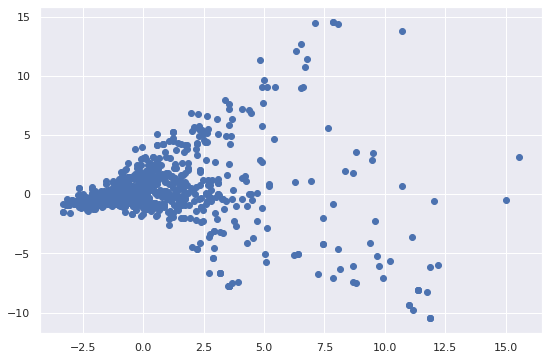

In [151]:
# Visualize 2 components of PCA
x_train_pca = x_train_scaled
pca_plot = PCA(n_components=2)
comp = pca_plot.fit_transform(x_train_pca)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

### Structure Train & Test Datasets - Nutrition Score Regression

Now, let's conduct regression on the `nutrition-score-uk_100g` variable to get a more precise predictive model. We will still conduct a PCA on the dataset and retain 175 variables since the feature set is the same as that for the previous classification model.

In [152]:
# Use sklearn to split data into train and test sets
features = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'nutrition-score-uk_100g'])
labels = food_df[['nutrition-score-uk_100g']]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=175)
pca.fit(x_train_scaled)
x_test = pca.transform(x_test_scaled)
x_train = pca.transform(x_train_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


### Linear Regression Models


In [153]:
# Train linear regression model without regularization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(x_train, y_train)
print("R-squared value on training set is:", round(reg.score(x_train, y_train)*100, 2), "%")
y_predict_train = reg.predict(x_train)
rmse_train = pow(mean_squared_error(y_train, y_predict_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

print("R-squared value on test set is:", round(reg.score(x_test, y_test)*100, 2), "%")
y_predict_test = reg.predict(x_test)
rmse_test = pow(mean_squared_error(y_test, y_predict_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 87.77 %
RMSE on training set is: 3.22
R-squared value on test set is: 85.18 %
RMSE on test set is: 3.65


The results are ok - we have achieved an R-squared value of 74.02% on the test set, and there is clearly no signs of overfitting.

Now, let's try adding in some degree of regularization to see if we can do even better. We will use Ridge regularization here to deal with heavier weights:

Hmm...it seems the result after regularization isn't that good. We actually arrived at lower R-sqaured scores despite similar RMSE values. Therefore, we will stick to using the OLS linear regression model for now. Let's see if we can do better with more complex models.

## Description of Challenges and Obstacles Faced

Originally, we planned on predicting the carbon footprint of foods in addition to the nutrition score of foods. However, we soon realized the dataset did not have nearly enough observations with carbon footprint data and had to scrap this element from our project.

In the classification and regression parts of the project, we run into the challenge of overfitting and ineffective regularization. For the random forest regressor, although the R-squared value on the training set is really high, there exists a large gap between the R-squared values of the train and test set. We had to manually reduce the number of estimators and the max depth of trees to regularize our model. For the regularized linear regression part, we started with ElasticNet, but it turned out to have very poor performance. So we tested using Lasso and Ridge regression separately to identify the issue. Through testing, we realized that Lasso regression has a poor performance, so we decided to go with the single Ridge regression.

We ran into multiple obstacles with the computer vision aspect of this project. First, we had technical difficulty getting the MXNet framework to work properly and had to switch to TensorFlow. Additionally, we faced problems with overfitting. Originally, the model had a 100% accuracy on the training data, but around a 38% accuracy on the test set. In order to address this, we added a validation set and stopped training our model when validation loss increased twice. This reduced the overfitting and improved our test accuracy to 43.45%.

## Potential Next Steps and Future Direction

There can definitely be improvements in how we first initially remove sparsely populated columns from our raw dataset. Instead of just relying on intuition to determine which columns to keep, perhaps we can algorithmically decide which columns to keep by mathematically determining how many non-null values the column has.

We are also thinking of expanding our dataset by joining the current food nutrition dataset with other food-related datasets. By doing so, we will be able to explore variables that can serve as better predictors of food nutrition scores and energy levels. Also, if we can create a large aggregation of food data, we will be able to run neural networks and deep learning models to evaluate nutrition scores and energy levels more accurately.

There is also plenty of room to improve our computer vision section. First, we can better scale up our process for retrieving images. Speeding this up is essential if we increase our image set. Additionally, although we were able to reduce overfitting in our computer vision model, it is still present. In the future, we should attempt to reduce this further by getting a better training set. We can do this by merging our current dataset with one that has better/multiple images for the foods. We can also use transformations, such as rotation and reflection, to manually augment our training set to help reduce overfitting.

Besides all the current models and objectives, we are also considering developing a recommendation system for people from different nationalities with different nutritional needs and providing a picture of the image. We can explore the popularity of food in each country and make recommendations according to their nutrition score and energy level. Then, we scan through our database of images and select the ones that match the preferences of our customers as the final output.